In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import medfilt

from mpl_toolkits.axes_grid1.inset_locator import mark_inset
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes

# Static

In [2]:
def getStaticData(name, from_ = 0, to_ = -1):
    sCal0 = np.genfromtxt(name, skip_header = 2)
    sCal0 = sCal0[from_:to_, :2] - sCal0[0, 0]
    return sCal0.T

def getIntervals(p, threshold = 0.5):
    d = np.diff(p)
    ad = medfilt(abs(d), kernel_size = 101)
    
    filtered = ad.copy()
    up = ad >= threshold
    low = ad < threshold
    filtered[up] = 1
    filtered[low] = 0
    
    changes = np.diff(filtered)
    ones = np.where(changes == 1)[0]
    negative = np.where(changes == -1)[0]
    
    t = 0.7
    baseline = (0, ones[0])
    top = int(t * (ones[1] - negative[0])) + negative[0], ones[1]
    baseline2 = int(t * (len(p) - negative[1])) + negative[1], len(p)
    
    return baseline, top, baseline2

def getStatistics(p, intervals):
    data = [p[i[0] : i[1]] for i in intervals]
    return [(np.mean(d), np.std(d)) for d in data]

def getLabels(statistics):
    return [r'$%.1f \pm %.1f$ $\mu$W'%(s) for s in statistics]

def getTimes(t, intervals, extra = 0.2):
    times = []
    for x, y in intervals:
        l = int((1 - extra)*x)
        h = int((1 + extra)*y)
        if h >= len(t):
            h = len(t) -1
        times.append((t[l], t[h]))
    return times

def makePlot(t, p, intervals):
    fig, ax = plt.subplots(figsize = (5, 4.5))
    ax.plot(t, p)
    
    statistics = getStatistics(p, intervals)
    labels = getLabels(statistics)
    times = getTimes(t, intervals)
    
    for i in range(len(labels)):
        l = labels[i]
        t = times[i]
        p = statistics[i][0]
        p = [p, p]
        ax.plot(t, p, label = l, alpha = 0.7)

    ax.set_xlabel('Tiempo (s)')
    ax.set_ylabel('Potencia ($\mu$W)')
    
    ymin = ax.get_ylim()[0]
    ax.set_ylim(ymin, 310)
    plt.legend()
    
    fig.tight_layout()
    
    return fig

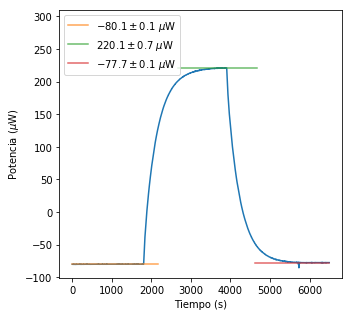

In [3]:
t, p = getStaticData("Static/staticCalibrationJB19112018.txt", to_ = 6500)
i = getIntervals(p)
fig = makePlot(t, p, i)

fig.savefig("Static/Calibration0.png", dpi = 300)

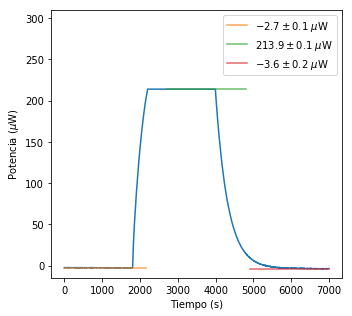

In [4]:
t, p = getStaticData("Static/sdCalibration.txt", to_ = 7000)
i = getIntervals(p)
fig = makePlot(t, p, i)

fig.savefig("Static/Calibration1.png", dpi = 300)

# Dynamic

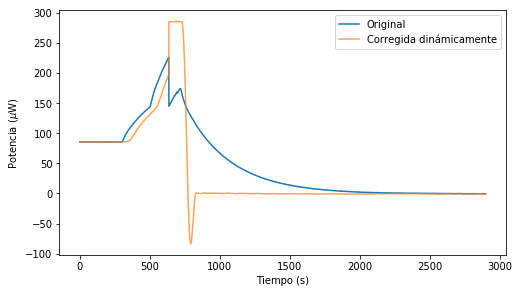

In [5]:
t, p, q, pc, qc = np.genfromtxt("Dynamic/dynamicCalibration.txt", skip_header = 2).T

fig, ax = plt.subplots(figsize=(8, 4.5))
ax.plot(t, p, label = "Original")
ax.plot(t, pc, label = "Corregida dinámicamente", alpha = 0.7)

ax.set_xlabel('Tiempo (s)')
ax.set_ylabel('Potencia ($\mu$W)')

plt.legend()

fig.savefig("Dynamic/dynamic.png", dpi = 300)

plt.show()

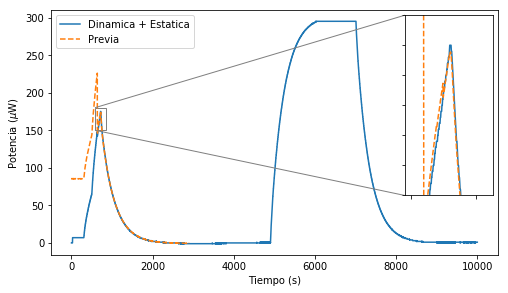

In [6]:
data = np.genfromtxt("sdCalibrationRR.txt", skip_header = 2)
tn, pn, q, pc, qc = data[:10000].T
fig, ax = plt.subplots(figsize = (8, 4.5))

axins = zoomed_inset_axes(ax, 8)#, loc = 2) # zoom-factor: 2.5, location: upper-left

for axes in (ax, axins):
    axes.plot(tn, pn*1000, label = "Dinamica + Estatica")
#     axes.plot(tn, pc*1000, label = "Corregida dinámicamente", alpha = 0.7)
    axes.plot(t, p, '--', label = 'Previa')

ax.set_xlabel('Tiempo (s)')
ax.set_ylabel('Potencia ($\mu$W)')

ax.legend(loc = 2)

axins.set_xlim(580, 850) # apply the x-limits
axins.set_ylim(150, 180) # apply the y-limits

plt.yticks(visible=False)
plt.xticks(visible=False)

mark_inset(ax, axins, loc1=2, loc2=3, fc="none", ec="0.5")

fig.savefig("Both.png", dpi = 300)

plt.show()